In [1]:
# 引入依赖库
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from models import BidirectionalLSTM,STC,LSTMMain,LSTM
from module import ScaledDotProductAttention,TemporalConvNet,TemporalBlock,KAN
from utils import *
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os
from Net import *

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
# 必要参数定义
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 训练设备,如果NVIDIA GPU已配置，会自动使用GPU训练
train_ratio = 0.8  # 训练集比例
val_ratio = 0.1  # 验证集比例
test_ratio = 0.1  # 测试集比例
batch_size = 50  # 批大小，若用CPU，建议为1
input_length = 4  # 每个batch的输入数据长度，多步预测建议长，单步预测建议短
output_length = 1  # 每个batch的输出数据长度，1为单步预测，1以上为多步预测
loss_function = 'MSE'  # 损失函数定义
learning_rate = 0.01  # 基础学习率
weight_decay = 0.001  # 权重衰减系数
num_blocks = 2  # lstm堆叠次数
dim = 64  # 隐层维度
interval_length = 55000  # 预测数据长度，最长不可以超过总数据条数
scalar = True  # 是否使用归一化
scalar_contain_labels = True  # 归一化过程是否包含目标值的历史数据
target_value = 'T (degC)'  # 需要预测的列名，可以在excel中查看
# 多步，单步标签
if output_length > 1:
    forecasting_model = 'multi_steps'
else:
    forecasting_model = 'one_steps'

In [3]:
csv_path = "./weather.csv"
df = pd.read_csv(csv_path, encoding='utf-8')

In [4]:
print(df.shape)

(52696, 22)


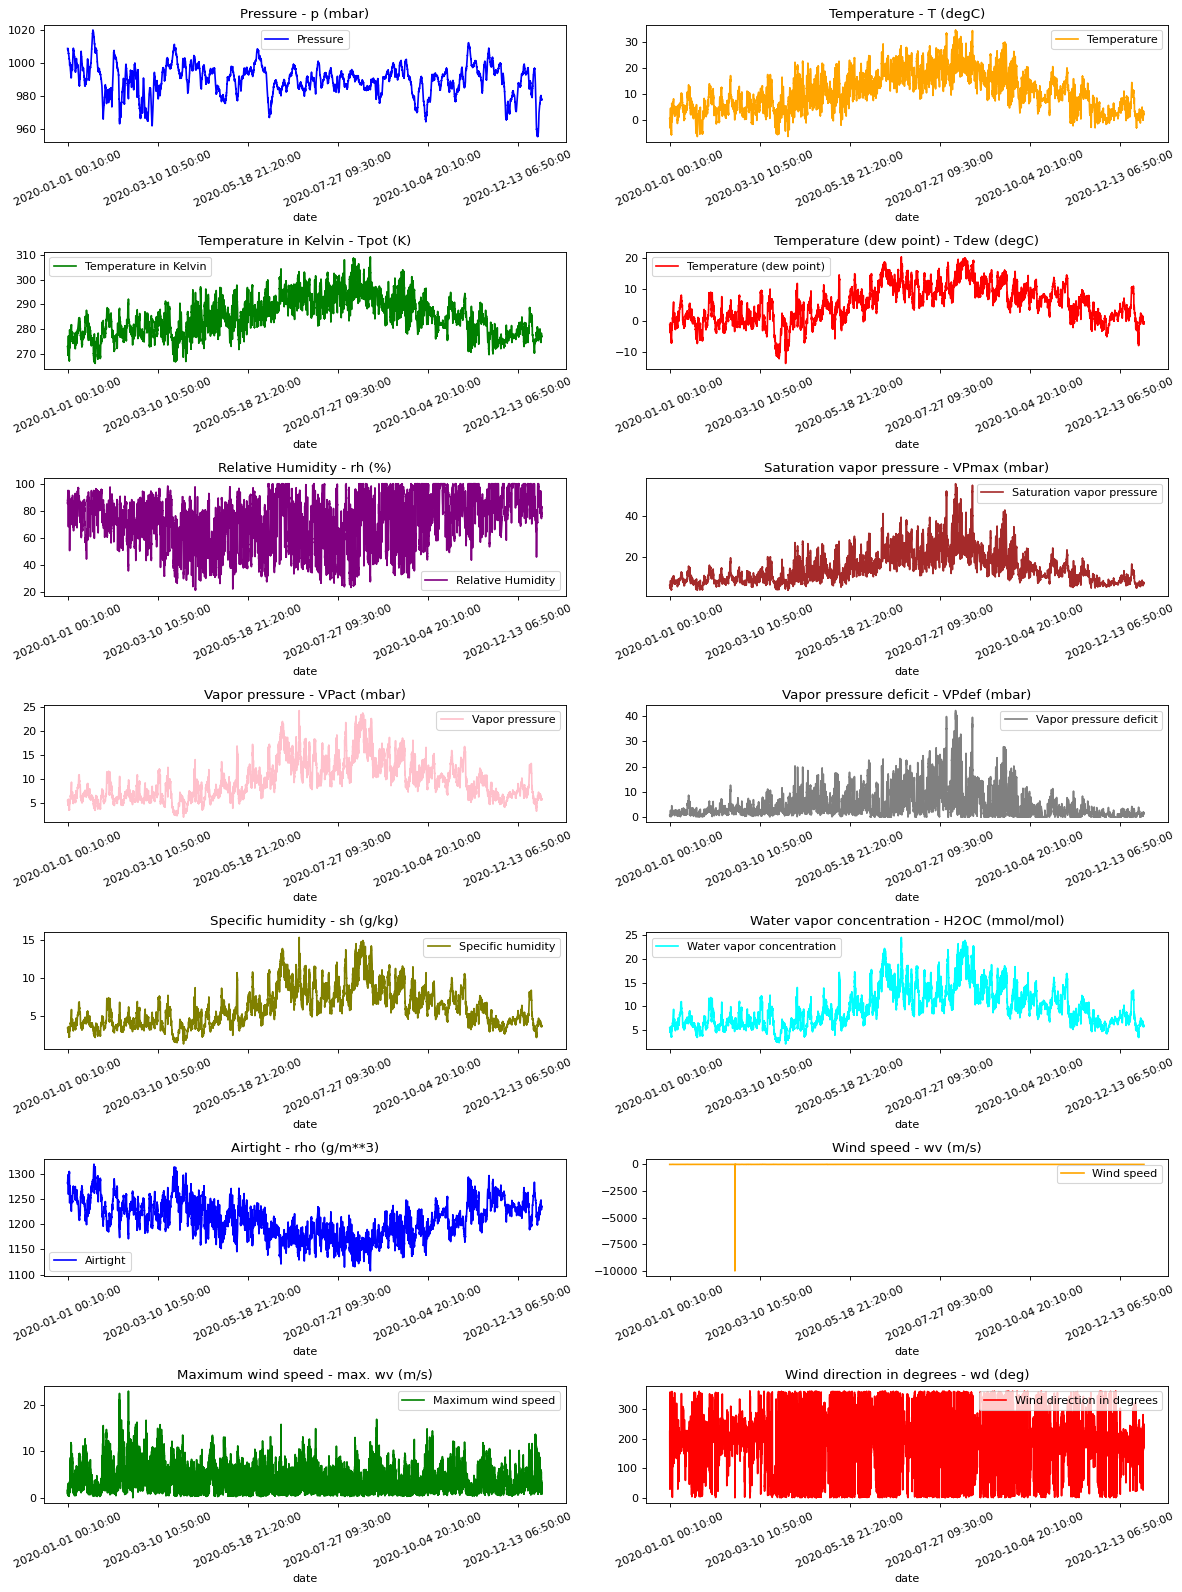

In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "date"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [6]:
print(
    "选取的参数指标是:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

选取的参数指标是: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
date,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,6.43,0.89,3.42,1280.62,1.02
2020-01-01 00:20:00,1008.76,0.75,6.45,0.95,3.39,1280.33,0.43
2020-01-01 00:30:00,1008.66,0.73,6.44,0.96,3.39,1280.29,0.61
2020-01-01 00:40:00,1008.64,0.37,6.27,0.86,3.35,1281.97,1.11
2020-01-01 00:50:00,1008.61,0.33,6.26,0.79,3.38,1282.08,0.49


In [7]:
# 原始数据集存在重复项，要进行去重
df.drop_duplicates(subset=["date"],keep='first',inplace=True)

In [8]:
print(df.keys())

Index(['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)',
       'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT'],
      dtype='object')


In [9]:

#wind speed中含有明显的异常值，需进行去除
df['z_score'] = (df['wv (m/s)'] - df['wv (m/s)'].mean()) / df['wv (m/s)'].std()
# 过滤掉 Z-Score 大于 3 或小于 -3 的数据点
df['wv (m/s)'][(df['z_score'] < -3) | (df['z_score'] > 3)] = 0

/tmp/ipykernel_26803/3152412068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wv (m/s)'][(df['z_score'] < -3) | (df['z_score'] > 3)] = 0


In [10]:
df['Date Time'] = pd.to_datetime(df['date'])  # 确保时间列是日期时间格式
df.set_index('Date Time', inplace=True)  # 将时间列设为索引

# 填充缺失值
df.fillna(method='pad', inplace=True)

# 选择目标列和观察列
target = df['T (degC)']
observed_cov = df[['p (mbar)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']]

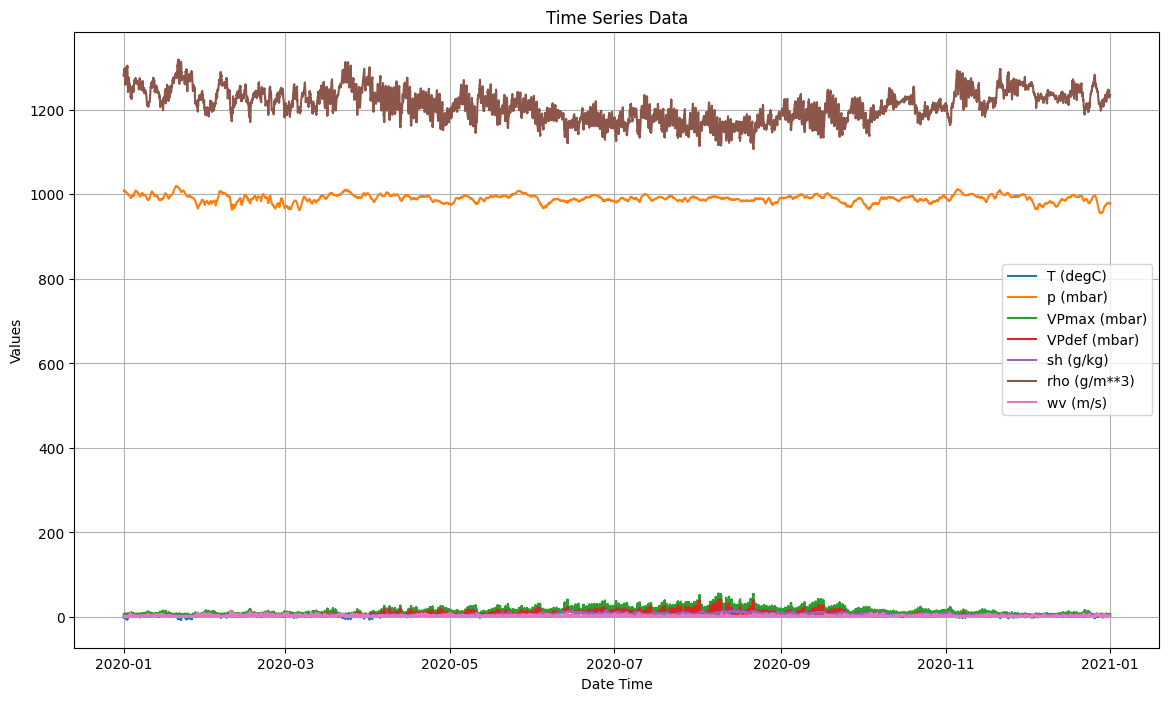

In [11]:
# 绘制目标和观察列
plt.figure(figsize=(14, 8))

# 绘制每一列
for column in ['T (degC)', 'p (mbar)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']:
    plt.plot(df.index, df[column], label=column)

plt.title('Time Series Data')
plt.xlabel('Date Time')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [12]:
# 获取指定列的总结统计信息
selected_columns = ['T (degC)', 'p (mbar)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']
summary = df[selected_columns].describe()

# 打印出选择列的总结统计信息
print(summary)


           T (degC)      p (mbar)  VPmax (mbar)  VPdef (mbar)     sh (g/kg)  \
count  52695.000000  52695.000000  52695.000000  52695.000000  52695.000000   
mean      10.818476    989.989203     14.487217      4.810218      6.111212   
std        7.468546      9.207234      7.632931      5.539336      2.561531   
min       -6.440000    955.580000      3.770000      0.000000      1.300000   
25%        4.590000    984.800000      8.480000      1.170000      4.070000   
50%       10.230000    990.920000     12.480000      2.740000      5.610000   
75%       16.180000    995.930000     18.420000      6.440000      7.620000   
max       34.800000   1020.070000     55.670000     42.100000     15.400000   

       rho (g/m**3)      wv (m/s)  
count  52695.000000  52695.000000  
mean    1210.881746      2.185705  
std       36.429680      1.601631  
min     1107.380000      0.000000  
25%     1183.900000      1.000000  
50%     1210.800000      1.770000  
75%     1236.550000      2.920000  


In [13]:
df_1=df[selected_columns]
df_1.head()

,T (degC),p (mbar),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
2020-01-01 00:10:00,0.71,1008.89,6.43,0.89,3.42,1280.62,1.02
2020-01-01 00:20:00,0.75,1008.76,6.45,0.95,3.39,1280.33,0.43
2020-01-01 00:30:00,0.73,1008.66,6.44,0.96,3.39,1280.29,0.61
2020-01-01 00:40:00,0.37,1008.64,6.27,0.86,3.35,1281.97,1.11
2020-01-01 00:50:00,0.33,1008.61,6.26,0.79,3.38,1282.08,0.49


In [14]:
#  读取数据
df = df_1[:interval_length]
features_num = 7  # 请手动输入特征维度数量
if features_num > 1:
    features_ = df.values
else:
    features_ = df[target_value].values
labels_ = df[target_value].values
# 初步划分训练集、验证集、测试集
split_train_val, split_val_test = int(len(features_)*train_ratio),\
                                  int(len(features_)*train_ratio)+int(len(features_)*val_ratio)

In [15]:
#  数据标准化
if scalar:
    #min-max scalar
    train_features_ = features_[:split_train_val]
    val_test_features_ = features_[split_train_val:]
    scalar = preprocessing.MinMaxScaler()
    if features_num == 1:
        train_features_ = np.expand_dims(train_features_, axis=1)
        val_test_features_ = np.expand_dims(val_test_features_, axis=1)
    train_features_ = scalar.fit_transform(train_features_)
    val_test_features_ = scalar.transform(val_test_features_)
    # 重新将数据进行拼接
    features_ = np.vstack([train_features_, val_test_features_])
    if scalar_contain_labels:
        labels_ = features_[:, -1]

if len(features_.shape) == 1:
    features_ = np.expand_dims(features_,0).T
features, labels = get_rolling_window_multistep(output_length, 0, input_length,
                                                features_.T, np.expand_dims(labels_, 0))

data preparing: 100%|██████████| 52691/52691 [01:10<00:00, 751.65it/s] 


In [16]:
#  构建数据集
labels = torch.squeeze(labels, dim=1)
features = features.to(torch.float32)
labels = labels.to(torch.float32)
split_train_val, split_val_test = int(len(features)*train_ratio), int(len(features)*train_ratio)+int(len(features)*val_ratio)
train_features, train_labels = features[:split_train_val], labels[:split_train_val]
val_features, val_labels = features[split_train_val:split_val_test], labels[split_train_val:split_val_test]
test_features, test_labels = features[split_val_test:], labels[split_val_test:]

In [17]:
#  数据管道构建，此处采用torch高阶API
train_Datasets = TensorDataset(train_features.to(device), train_labels.to(device))
train_Loader = DataLoader(batch_size=batch_size, dataset=train_Datasets)
val_Datasets = TensorDataset(val_features.to(device), val_labels.to(device))
val_Loader = DataLoader(batch_size=batch_size, dataset=val_Datasets)
test_Datasets = TensorDataset(test_features.to(device), test_labels.to(device))
test_Loader = DataLoader(batch_size=batch_size, dataset=test_Datasets)

In [18]:
    
class LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size, lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.linear = nn.Linear(lstm_hidden,8, output_len)

    def forward(self, input_seq):
        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        out = self.KAN(out,True)
        #out = self.linear(out)
        out = out.view(ula.shape[0], ula.shape[1], -1)
        out = out[:, -1, :]
        return out

class TCN_LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN1 = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)
        self.linear = nn.Linear(lstm_hidden, output_len)
    def forward(self, input_seq):        

        #input_seq = input_seq.contiguous()

        #input_seq = self.KAN1(input_seq,True)

        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        #out = self.KAN1(out)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)

        out = self.KAN1(out,True)

        #out = self.linear(out)
        #outclass TCN_LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN1 = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)
        self.linear = nn.Linear(lstm_hidden, output_len)
    def forward(self, input_seq):        

        #input_seq = input_seq.contiguous()

        #input_seq = self.KAN1(input_seq,True)

        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        #out = self.KAN1(out)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)

        out = self.KAN1(out,True)

        #out = self.linear(out)
        #outclass TCN_LSTM_KAN(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM_KAN, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.KAN1 = KAN([lstm_hidden,64,output_len],grid_size=2)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)
        self.linear = nn.Linear(lstm_hidden, output_len)
    def forward(self, input_seq):        

        #input_seq = input_seq.contiguous()

        #input_seq = self.KAN1(input_seq,True)

        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        #out = self.KAN1(out)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)

        out = self.KAN1(out,True)

        #out = self.linear(out)
        #out = self.KAN1(out,True)
        out = out.view(ula.shape[0], ula.shape[1], -1)

        out = out[:, -1, :]

        return out

class TCN_LSTM(nn.Module):
    def __init__(self, input_size, output_len, lstm_hidden, lstm_layers, batch_size, device="cpu"):
        super(TCN_LSTM, self).__init__()
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lstmunit = LSTM(input_size , lstm_hidden, lstm_layers, batch_size, device,bidirectional_en = False)
        self.linear = nn.Linear(lstm_hidden, output_len)
        self.tcn = TemporalConvNet(num_inputs=1, num_channels=[1, 1, 1, 1], kernel_size=3, dropout=0.3)

    def forward(self, input_seq):

        ula, h_out = self.lstmunit(input_seq)
        out = ula.contiguous().view(ula.shape[0] * ula.shape[1], self.lstm_hidden)
        out = out.unsqueeze(1)
        out = self.tcn(out)
        out = out.squeeze(1)
        out = self.linear(out)
        out = out.view(ula.shape[0], ula.shape[1], -1)
        out = out[:, -1, :]
        return out
    


In [19]:
#  模型定义


model_name = 'TCN_LSTM_KAN'



if model_name == 'LSTM':
    model = LSTMMain(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)
elif model_name == 'LSTM_KAN':
    model = LSTM_KAN(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)
elif model_name == 'TCN_LSTM_KAN':
    learning_rate = 0.001
    model = TCN_LSTM_KAN(input_size=7, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)
elif model_name == 'TCN_LSTM':
    model = TCN_LSTM(input_size=features_num, output_len=output_length,
                                  lstm_hidden=dim, lstm_layers=num_blocks, batch_size=batch_size, device=device)    
model.to(device)
if loss_function == 'MSE':
    loss_func = nn.MSELoss(reduction='mean')

In [20]:
#  训练代数定义
epochs = 21
#  优化器定义，学习率衰减定义
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.00001)

seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [21]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import r2_score

# Lists to store MAE, RMSE, and R² for each epoch
train_mae_history = []
train_rmse_history = []
train_r2_history = []
val_mae_history = []
val_rmse_history = []
val_r2_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss_sum = 0
    train_mae_sum = 0
    train_rmse_sum = 0
    all_train_preds = []
    all_train_labels = []
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()
        
        # Store predictions and labels for R² calculation
        all_train_preds.append(prediction.detach().cpu().numpy())
        all_train_labels.append(label_.detach().cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        train_mae_sum += mae
        train_rmse_sum += rmse

    # Calculate R² for training data for the entire epoch
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    train_r2 = r2_score(all_train_labels, all_train_preds)
    
    # Record each epoch's metrics
    train_mae_history.append(train_mae_sum / (step + 1))  # Average MAE per epoch
    train_rmse_history.append(train_rmse_sum / (step + 1))  # Average RMSE per epoch
    train_r2_history.append(train_r2)

    print(f"Epoch {epoch}: Train Loss = {train_loss_sum:.4f}, Train MAE = {train_mae_history[-1]:.4f}, Train RMSE = {train_rmse_history[-1]:.4f}, Train R² = {train_r2:.4f}")

    # Validation
    model.eval()
    val_loss_sum = 0
    val_mae_sum = 0
    val_rmse_sum = 0
    all_val_preds = []
    all_val_labels = []
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()
        
        # Store predictions and labels for R² calculation
        all_val_preds.append(prediction.cpu().numpy())
        all_val_labels.append(label_.cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        val_mae_sum += mae
        val_rmse_sum += rmse

    # Calculate R² for validation data for the entire epoch
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    val_r2 = r2_score(all_val_labels, all_val_preds)
    
    # Record each epoch's metrics
    val_mae_history.append(val_mae_sum / (val_step + 1))  # Average MAE per epoch
    val_rmse_history.append(val_rmse_sum / (val_step + 1))  # Average RMSE per epoch
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch}: Val Loss = {val_loss_sum:.4f}, Val MAE = {val_mae_history[-1]:.4f}, Val RMSE = {val_rmse_history[-1]:.4f}, Val R² = {val_r2:.4f}")

    # Save best model
    if epoch == 0 or val_loss_sum < val_best:
        val_best = val_loss_sum
        #torch.save(model.state_dict(), './TCN_LSTM_KAN/TCN_LSTM_KAN_best')  # Save best weights
        print("val_best change")
    '''
    # Save model every 10 epochs
    if epoch % 10 == 0 and epoch >= 10:
        torch.save(model.state_dict(), f'./TCN_LSTM_KAN/TCN_LSTM_KAN_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")
    '''

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_26803/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 0: Train Loss = 8.8435, Train MAE = 0.0700, Train RMSE = 0.0826, Train R² = 0.2682
Epoch 0: Val Loss = 0.2344, Val MAE = 0.0365, Val RMSE = 0.0455, Val R² = 0.7979
val_best change


/tmp/ipykernel_26803/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 1: Train Loss = 2.0978, Train MAE = 0.0362, Train RMSE = 0.0462, Train R² = 0.8264
Epoch 1: Val Loss = 0.2269, Val MAE = 0.0362, Val RMSE = 0.0448, Val R² = 0.8046
val_best change


/tmp/ipykernel_26803/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 2: Train Loss = 1.9314, Train MAE = 0.0345, Train RMSE = 0.0442, Train R² = 0.8402
Epoch 2: Val Loss = 0.2055, Val MAE = 0.0341, Val RMSE = 0.0428, Val R² = 0.8228
val_best change


/tmp/ipykernel_26803/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 3: Train Loss = 1.8212, Train MAE = 0.0335, Train RMSE = 0.0430, Train R² = 0.8493
Epoch 3: Val Loss = 0.1975, Val MAE = 0.0330, Val RMSE = 0.0417, Val R² = 0.8296
val_best change


/tmp/ipykernel_26803/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 4: Train Loss = 1.7404, Train MAE = 0.0328, Train RMSE = 0.0421, Train R² = 0.8560
Epoch 4: Val Loss = 0.1871, Val MAE = 0.0320, Val RMSE = 0.0406, Val R² = 0.8387
val_best change


/tmp/ipykernel_26803/2213784642.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


KeyboardInterrupt: 

In [24]:
np.savez('./plot/TCN_LSTM_KAN_metrics_history.npz', 
         train_mae=train_mae_history, 
         train_rmse=train_rmse_history, 
         train_r2=train_r2_history, 
         val_mae=val_mae_history, 
         val_rmse=val_rmse_history, 
         val_r2=val_r2_history)

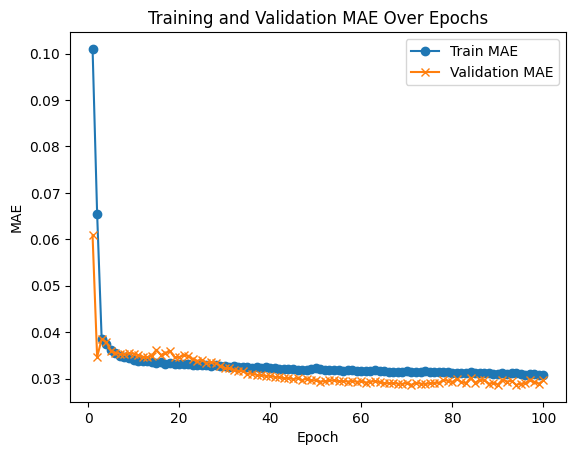

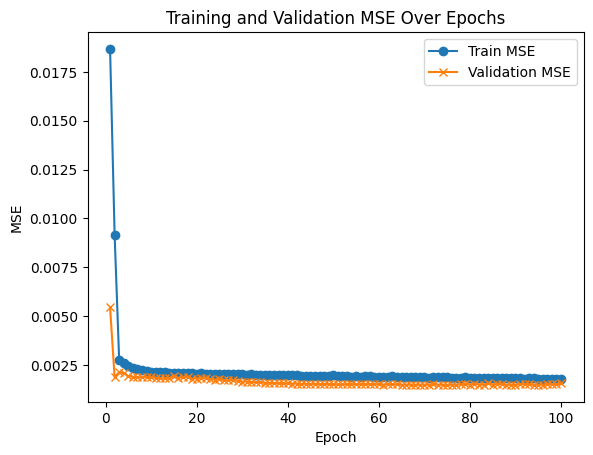

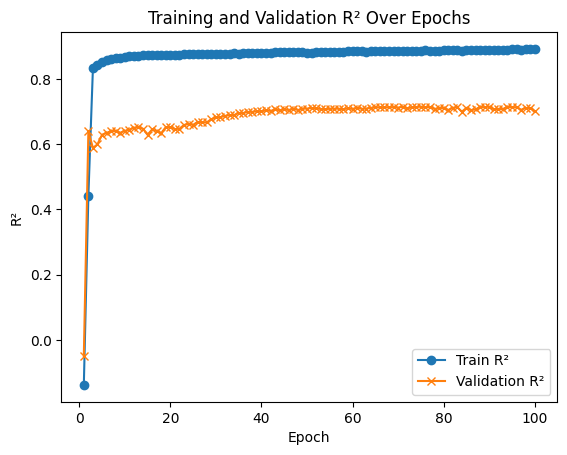

In [24]:
# Load the metrics data
metrics_data = np.load('./TCN_LSTM_KAN/TCN_LSTM_KAN_metrics_history.npz')
train_mae = metrics_data['train_mae']
train_mse = metrics_data['train_mse']
train_r2 = metrics_data['train_r2']
val_mae = metrics_data['val_mae']
val_mse = metrics_data['val_mse']
val_r2 = metrics_data['val_r2']

# X-axis (epochs)
epochs_range = range(1, len(train_mae) + 1)

# Plotting MAE
plt.plot(epochs_range, train_mae, label='Train MAE', marker='o', linestyle='-')
plt.plot(epochs_range, val_mae, label='Validation MAE', marker='x', linestyle='-')
plt.title("Training and Validation MAE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

# Plotting MSE
plt.plot(epochs_range, train_mse, label='Train MSE', marker='o', linestyle='-')
plt.plot(epochs_range, val_mse, label='Validation MSE', marker='x', linestyle='-')
plt.title("Training and Validation MSE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Plotting R²
plt.plot(epochs_range, train_r2, label='Train R²', marker='o', linestyle='-')
plt.plot(epochs_range, val_r2, label='Validation R²', marker='x', linestyle='-')
plt.title("Training and Validation R² Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.legend()
plt.show()


In [106]:
#  训练及验证循环
print("——————————————————————Training Starts——————————————————————")
for epoch in range(epochs):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        
        feature_ = feature_.permute(0,2,1)

        prediction = model(feature_)

        loss = loss_func(prediction, label_)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        
        
        optimizer.step()
        train_loss_sum+=loss.item()
    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    #  验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()
    if epoch == 0:
        val_best = val_loss_sum
        print('val_loss = ' + str(val_loss_sum))
    else:
        print('val_loss = ' + str(val_loss_sum))
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './TCN')  # 保存最好权重
            print("val_best change")
print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_217/2288106843.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


epochs = 0
train_loss = 7.540911288233474
val_loss = 0.13447238109074533
epochs = 1
train_loss = 1.8470914406061638
val_loss = 0.11996027559507638
val_best change
epochs = 2
train_loss = 1.5406206285988446
val_loss = 0.11875776736997068
val_best change
epochs = 3
train_loss = 1.4323060667375103
val_loss = 0.11187396902823821
val_best change
epochs = 4
train_loss = 1.3571715835423674
val_loss = 0.10773513547610492
val_best change
epochs = 5
train_loss = 1.3169630070624407
val_loss = 0.1141858478076756
epochs = 6
train_loss = 1.2832761531753931
val_loss = 0.11332337895873934
epochs = 7
train_loss = 1.248472236446105
val_loss = 0.11734006385086104
epochs = 8
train_loss = 1.2378880238102283
val_loss = 0.11540546454489231
epochs = 9
train_loss = 1.2159034010837786
val_loss = 0.11379445681814104
epochs = 10
train_loss = 1.2100033014139626
val_loss = 0.12116993026575074
epochs = 11
train_loss = 1.2006458984105848
val_loss = 0.11867700068978593
epochs = 12
train_loss = 1.18508265534183
val_los

In [107]:
#  测试集预测
model.load_state_dict(torch.load('./TCN'))  # 调用权重
test_loss_sum = 0
step = 0
#  测试集inference
print("——————————————————————Testing Starts——————————————————————")
for step, (feature_, label_) in enumerate(test_Loader):
    feature_ = feature_.permute(0, 2, 1)
    with torch.no_grad():
         if step ==0:
            prediction = model(feature_)
            pre_array = prediction.cpu()
            label_array = label_.cpu()
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
         else:
            prediction = model(feature_)
            pre_array = np.vstack((pre_array, prediction.cpu()))
            label_array = np.vstack((label_array, label_.cpu()))
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
print("test loss = " + str(test_loss_sum))
print("——————————————————————Testing Ends——————————————————————")

——————————————————————Testing Starts——————————————————————
test loss = 0.1255763866356574
——————————————————————Testing Ends——————————————————————


——————————————————————Post-Processing——————————————————————


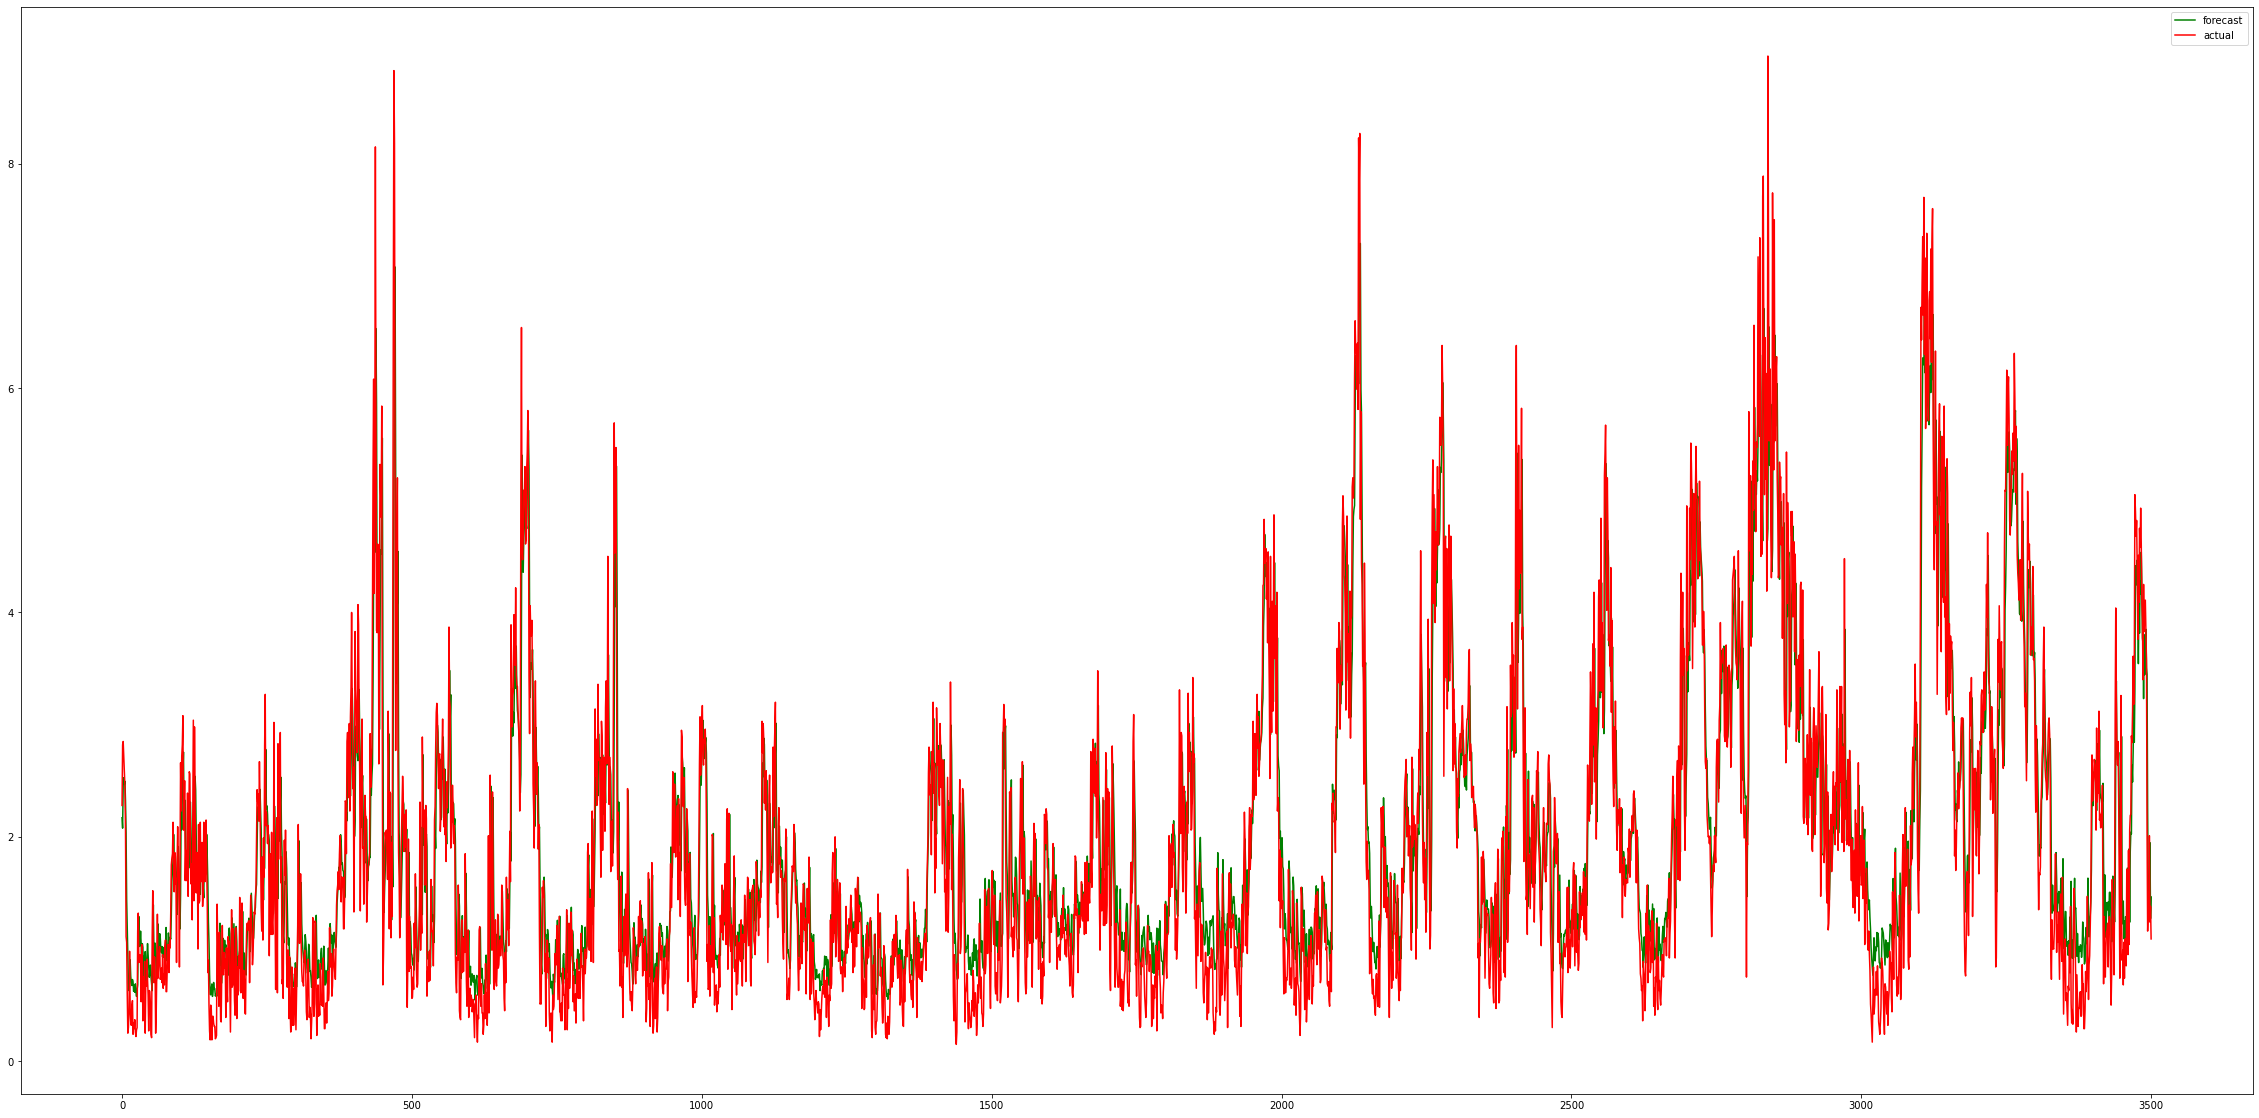

MSE loss=0.33809979386327854
MAE loss=0.42835615648337394
MAPE loss=0.3719083435293512
R2=0.8299562852165474


In [108]:
# 数据后处理，单步预测绘制全部预测值的图像，多步预测仅绘制第一个batch的输出图像
#  逆归一化过程及绘制图像
print("——————————————————————Post-Processing——————————————————————")
#test_labels = torch.tensor(test_labels)

if scalar_contain_labels and scalar :
    pre_inverse = []
    test_inverse = []
    if features_num == 1 and output_length == 1:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    elif features_num>1:
        if isinstance(pre_array, np.ndarray):
            pre_array = torch.from_numpy(pre_array)
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(pre_array[0].shape[0], features_num-1),torch.unsqueeze(pre_array[pre_slice], dim=1)), 1))[:,-1]
            test_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(test_labels[0].shape[0], features_num-1), torch.unsqueeze(test_labels[pre_slice], dim=1)), 1))[:,-1]
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse)
        test_labels = np.array(test_inverse)
    else:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0], "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels, "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    #  计算衡量指标
    MSE_l = mean_squared_error(test_labels, pre_array)
    MAE_l = mean_absolute_error(test_labels, pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels, pre_array)
    R2 = r2_score(test_labels, pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)

else:
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0].cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels.cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    MSE_l = mean_squared_error(test_labels.cpu(), pre_array)
    MAE_l = mean_absolute_error(test_labels.cpu(), pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels.cpu(), pre_array)
    R2 = r2_score(test_labels.cpu(), pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)